# Imputing and Inferring Missing Data for HIV treatment
## Deborah Hanus 



In [1]:
%matplotlib inline
import numpy as np 
from hiv_treatment import HIVTreatment, visualize_hiv_history, always_do, random_policy
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from collections import defaultdict 

In [2]:
simulator = HIVTreatment()
treatments = range(4)
npatients = 100
maxN = 5

## Simulate baselines
### 1. Always apply the same action independently of reward

In [3]:
# create baseline data always performing one of the four actions 
states_baseline0, actions_baseline0, rewards_baseline0 = (simulator.generate_batch(num_patients=1, policy=always_do(0)))
states_baseline1, actions_baseline1, rewards_baseline1 = (simulator.generate_batch(num_patients=1, policy=always_do(1)))
states_baseline2, actions_baseline2, rewards_baseline2 = (simulator.generate_batch(num_patients=1, policy=always_do(2)))
states_baseline3, actions_baseline3, rewards_baseline3 = (simulator.generate_batch(num_patients=1, policy=always_do(3)))

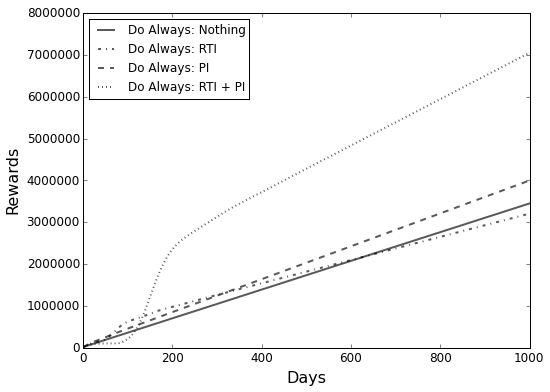

In [4]:
# plot results 
test_patient = np.random.randint(50)
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.ylabel('Rewards', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)

### 2. Apply a random policy 

In [5]:
# create batch data with a random policy 
def calculate_mean_and_error(npatients=1):
    rewards_all  = [] 
    for n in range(10): 
        states_random, actions_random, rewards_random = (simulator.generate_batch(num_patients=npatients))
        rewards_all.append(rewards_random[0,:])

    rewards_all = np.array(rewards_all)
    rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
    rewards_std = np.std(rewards_all, axis=0)
    lower = rewards_mean - rewards_std 
    upper = rewards_mean + rewards_std 
    return rewards_mean, lower, upper 


rand_mean, rand_lower, rand_upper = calculate_mean_and_error()

/Users/dhanus/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


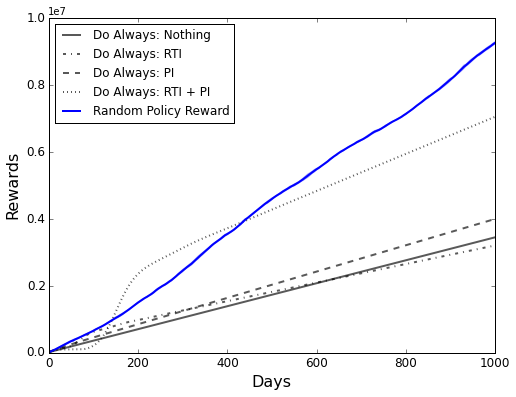

In [6]:
# plot against other baseline results 
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.plot(d,rand_mean, color='blue', lw=2, label="Random Policy Reward")
plt.fill_between(d, rand_lower, rand_upper, color='blue', alpha=.3)
plt.ylabel('Rewards', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)

###3. Apply fitted Q iteration to the randomly generated data

This replicates the results of Ernst 2006 [http://www.bg.ic.ac.uk/research/g.stan/CDC_2006.pdf]

In [11]:
# generate states using a random policy 
states, actions, rewards = simulator.generate_batch(npatients)

In [12]:
# define how an action will be encoded 
def encode_action(action): 
    a = np.array([0]*len(treatments))
    a[action] = 1
    return a 

In [13]:
# train a classifier 
X_train = np.array([np.append(states[i,j,:],encode_action(actions[i,j])) for i in range(actions.shape[0]) for j in range(actions.shape[1])])
y_train = np.array([rewards[i,j] for i in range(rewards.shape[0]) for j in range(rewards.shape[1])])
clf = ExtraTreesRegressor()
clf.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [14]:
# define an e-greedy Q-learning function 
def Q_policy(estimator, action_coder, epsilon):
    def policy(state, rng):
        # Returns epsilon-greedy assignment of action determined from learned Q function                                                  
        if np.random.uniform(0,1,1)[0] > epsilon:
            return rng.choice(4)
        else:
            return np.argmax([estimator.predict(np.hstack([state,action_coder(a)])) for a in range(4)])
    return policy

In [15]:
rewards_all = []
epsilon=.9
for n in range(10):
    fq_states, fq_actions, fq_rewards = (simulator.generate_batch(num_patients=1,policy=Q_policy(clf, encode_action, epsilon)))
    rewards_all.append(fq_rewards)

fq_rewards_all = np.array(rewards_all)
fq_rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
fq_rewards_std = np.std(fq_rewards_all, axis=0)[0]
fq_lower = fq_rewards_mean - fq_rewards_std 
fq_upper = fq_rewards_mean + fq_rewards_std 

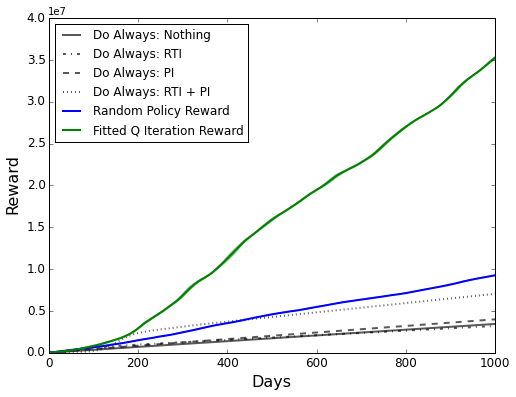

In [16]:
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.plot(d,rand_mean, color='blue', lw=2, label="Random Policy Reward")
plt.plot(d,fq_rewards_mean, color='green', lw=2, label="Fitted Q Iteration Reward")
plt.fill_between(d, rand_lower, rand_upper, color='blue', alpha=.4)
plt.fill_between(d, fq_lower, fq_upper, color='green', alpha=.4)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)

### 4. Impute the data for unknown states

In [20]:
states, actions, rewards = simulator.generate_batch(npatients)

In [21]:
def create_masks(npairs, nepisodes):
    # npairs must be less than half nepisodes 
    rindices = np.random.random_integers(1, nepisodes-1, npairs)
    indices = np.unique(np.concatenate([rindices, np.array([0, 199])])) 
    single_mask = [False]*(nepisodes+1)
    paired_mask = [False]*(nepisodes+1)
    for i in indices: 
        single_mask[i] = True
        paired_mask[i] = True
        paired_mask[i+1] = True 
    single_state_mask = [single_mask]*6
    paired_state_mask = [paired_mask]*6
    return  np.array(single_mask), np.array(paired_mask), np.array(single_state_mask), np.array(paired_state_mask)

single_mask, paired_mask, single_state_mask, paired_state_mask = create_masks(80, 200)

In [22]:
def mask_data(mask, state_mask, states, actions, rewards): 
    masked_rewards = mask*rewards
    masked_actions = mask*actions
    # for each patient 
    for n in range(actions.shape[0]):
        for i in range(actions.shape[1]-1): 
            if masked_actions[n,i+1] == 0: 
                masked_actions[n,i+1] = masked_actions[n,i]
    masked_states = np.ones(states.shape)
    for p in range(states.shape[0]): 
        masked_states[p,:,:] = state_mask.T*states[p,:,:]
    return (masked_states, masked_actions, masked_rewards)

states_sparse, actions_sparse, rewards_sparse = mask_data(single_mask, single_state_mask, states, actions, rewards)
states_paired, actions_paired, rewards_paired = mask_data(paired_mask, paired_state_mask, states, actions, rewards)

In [23]:
# implement Bayesian Linear Regression 
def get_known_indices(mask): 
    known_indices = [] 
    for i in range(len(mask)): 
        if mask[i]:
            known_indices.append(i)
    return np.array(known_indices)

# given w resample s        
def forward_filter(ptn, w, sigma, states, known_start, known_end): 
    dist = {} 
    for k in range(known_start, known_end):
        statek = states[ptn, k, :]
        statek = statek.reshape(6,1)
        ck = k-known_start+1
        d, u = np.linalg.eig(w)
        d = d.reshape([1,6])
        wk = np.dot(u, np.dot(d**ck , u.T).T)
        nu = np.dot(wk.T, statek)[0][0]
        tau = ck*sigma 
        dist[k] = (nu, tau)
    return dist

def back_propagation(state_given_w, sigma, known_start, known_end): 
    combined = {} 
    for k in range(known_start, known_end):
        mu_c = state_given_w[k][0] + 0 
        sigma_c = state_given_w[k][1] + sigma
        combined[k] = (mu_c, sigma_c)
    return combined
    
def simulate_gap(ptn, sigma, states, w, known_start, known_end):
    # forward filter
    state_given_w = forward_filter(ptn, w, sigma, states, known_start, known_end)
    # backward propagation
    state_dist = back_propagation(state_given_w, sigma,known_start, known_end) 
    for k in range(known_start, known_end):
        test = np.random.normal(state_dist[k][0], state_dist[k][1], size=[1,6])
        if np.isnan(test).any(): 
            print "k is ", k 
            print "output is ", test 
            print "mean of dist ", state_dist[k][0]
            print "sd of dist ", state_dist[k][1]
        states[ptn,k:k+1,:] = test 
    return states 

def sample_s(w, sigma, states, mask): 
    known = get_known_indices(mask)
    for n in range(npatients): 
        for i in range(len(known)-1):
            a = actions[n,known[i]]
            #print "w[%d] in state_sample" % (a), w[a].shape, w[a] 
            states = simulate_gap(n, sigma, states, w[a], known[i], known[i+1])
            #print "w[%d] in state_sample after simulate_gap" % (a), w[a].shape, w[a] 
    return states

# given s, resample w 
# maybe add a more informative prior; is the mean 1 or 0? 
def sample_w(v0, w, sigma, states, action2state):
    for a in range(4):
        state = np.array(action2state[a]['state'])
        next_state = np.array(action2state[a]['next_state'])
        vn = sigma*(1.0/(sigma*(1.0/v0)) + np.dot(next_state.T, next_state))
        w[a] = vn*(1/v0)*w[a] + (1.0/sigma**2)*np.dot(vn, np.dot(next_state.T,state))
        w[a] = threshold(w[a])
        #print "w[%d] in sample_w " % (a), w[a].shape, w[a]
    return w

def threshold(w):
    for i in range(w.shape[0]):
        for j in range(w.shape[1]): 
            if w[i,j] > .99: 
                w[i,j] = .99 
            if w[i,j] < 0: 
                w[i,j] = 0
    return w 

def process_states(states, actions): 
    action2state = defaultdict(lambda: defaultdict(list))
    for n in range(actions.shape[0]): 
        for j in range(actions.shape[1]-1):
            action2state[actions[n,j]]['state'].append(states[n,j,:])
            action2state[actions[n,j]]['next_state'].append(states[n,j+1,:]) 
    return action2state

Sample states and weights for the paired masked out data 

In [62]:
# Run Bayesian Linear Regression 
n = 0
nstates = 6
sigma = .01
w = {}
for t in treatments: 
    w[t] = np.identity(nstates)

v0 = 10 
# for paired baseline 
while n < maxN:
    # given w resample s
    states_paired = sample_s(w, sigma, states_paired, paired_mask)
    #print np.isnan(states[1,:]).any() 
    # given s resample w 
    action2state = process_states(states_paired, actions_paired) 
    w = sample_w(v0, w, sigma, states_paired, action2state) 
    n+=1

In [63]:
# fill in rewards 
def fill_in_rewards(states, actions, rewards):
    for patient in range(states.shape[0]):
        for episode in range(states.shape[1]):
            if rewards[patient, episode] == 0: 
                reward = simulator.perform_action_inferred_state(actions[patient, episode], states[patient, episode,:])
                rewards[patient, episode] = reward
    return rewards 
rewards_paired = fill_in_rewards(states_paired, actions_paired, rewards_paired)

In [64]:
# create training set to fit classifier 
# train a classifier 
def create_trained_classifier(states, actions, rewards): 
    Xtrain = np.array([np.append(states[i,j,:], encode_action(actions[i,j])) for i in range(actions.shape[0]) for j in range(actions.shape[1])])
    ytrain = np.array([rewards[i,j] for i in range(rewards.shape[0]) for j in range(rewards.shape[1])])
    clf = ExtraTreesRegressor()
    clf.fit(X_train, y_train)
    return clf

clf_paired = create_trained_classifier(states_paired, actions_paired, rewards_paired)

In [65]:
# create batch data with an egreedy policy 
rewards_all = []
epsilon=.9
for n in range(10):
    fq_states_paired, fq_actions_paired, fq_rewards_paired = (simulator.generate_batch(num_patients=1, policy=Q_policy(clf_paired, encode_action, epsilon)))
    rewards_all.append(fq_rewards_paired)

fqp_rewards_all = np.array(rewards_all)
fqp_rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
fqp_rewards_std = np.std(fqp_rewards_all, axis=0)[0]
fqp_lower = fqp_rewards_mean - fqp_rewards_std 
fqp_upper = fqp_rewards_mean + fqp_rewards_std 

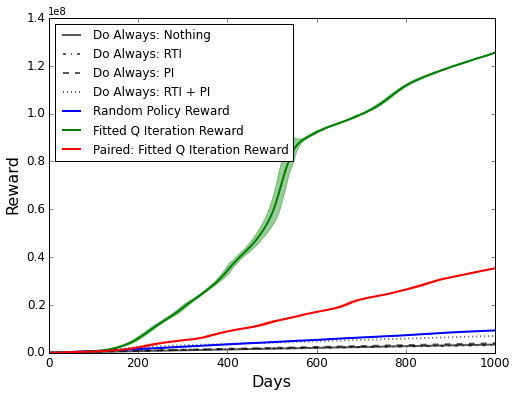

In [66]:
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.plot(d,rand_mean, color='blue', lw=2, label="Random Policy Reward")
plt.plot(d,fq_rewards_mean, color='green', lw=2, label="Fitted Q Iteration Reward")
plt.plot(d,fqp_rewards_mean, color='red', lw=2, label="Paired: Fitted Q Iteration Reward")
plt.fill_between(d, rand_lower, rand_upper, color='blue', alpha=.4)
plt.fill_between(d, fq_lower, fq_upper, color='green', alpha=.4)
plt.fill_between(d, fqp_lower, fqp_upper, color='red', alpha=.4)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)

Sample states and weights for the missing at random data 

In [67]:
# Run Bayesian Linear Regression 
nstates = 6 
n = 0
sigma = .01
w = {}
for t in treatments: 
    w[t] = np.identity(nstates)

v0 = 10 
# for paired baseline 
while n < maxN:
    # given w resample s
    states_sparse = sample_s(w, sigma, states_sparse, single_mask)
    action2state = process_states(states_sparse, actions_sparse) 
    w = sample_w(v0, w, sigma, states_sparse, action2state) 
    n+=1

In [68]:
rewards_sparse = fill_in_rewards(states_sparse, actions_sparse, rewards_sparse)
clf_sparse = create_trained_classifier(states_sparse, actions_sparse, rewards_sparse)

In [69]:
# create batch data with an egreedy policy 
rewards_all = []
epsilon=.9
for n in range(10):
    fq_states_sparse, fq_actions_sparse, fq_rewards_sparse = (simulator.generate_batch(num_patients=1, policy=Q_policy(clf_sparse, encode_action, epsilon)))
    rewards_all.append(fq_rewards_paired)

fqs_rewards_all = np.array(rewards_all)
fqs_rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
fqs_rewards_std = np.std(fqs_rewards_all, axis=0)[0]
fqs_lower = fqs_rewards_mean - fqs_rewards_std 
fqs_upper = fqs_rewards_mean + fqs_rewards_std 

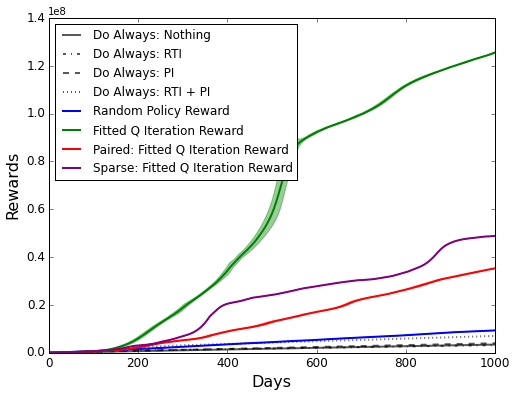

In [70]:
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.plot(d,rand_mean, color='blue', lw=2, label="Random Policy Reward")
plt.plot(d,fq_rewards_mean, color='green', lw=2, label="Fitted Q Iteration Reward")
plt.plot(d,fqp_rewards_mean, color='red', lw=2, label="Paired: Fitted Q Iteration Reward")
plt.plot(d,fqs_rewards_mean, color='purple', lw=2, label="Sparse: Fitted Q Iteration Reward")
plt.fill_between(d, rand_lower, rand_upper, color='blue', alpha=.4)
plt.fill_between(d, fq_lower, fq_upper, color='green', alpha=.4)
plt.fill_between(d, fqp_lower, fqp_upper, color='red', alpha=.4)
plt.fill_between(d, fqs_lower, fqs_upper, color='purple', alpha=.4)
plt.ylabel('Rewards', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)

### 5. Interpolate the unknown states 

In [71]:
# create batch data 
states, actions, rewards = simulator.generate_batch(npatients)
# mask out unknown states 
states_sparsei, actions_sparsei, rewards_sparsei = mask_data(single_mask, single_state_mask, states, actions, rewards)
states_pairedi, actions_pairedi, rewards_pairedi = mask_data(paired_mask, paired_state_mask, states, actions, rewards)

Impute unknown states using linear interpolation

In [72]:
def interpolate_states(states, mask): 
    known = get_known_indices(mask)
    for n in range(npatients): 
        for i in range(len(known)-1):
            for s in range(states.shape[2]): 
                #if known[i+1]-known[i] > 1: 
                states[n,(known[i]+1):known[i+1],s] = np.linspace(states[n,known[i],s], states[n,known[i+1],s], known[i+1]-known[i]+1)[1:-1]
    return states 
  
interpolated_states_sparse = interpolate_states(states_sparsei, single_mask)
interpolated_states_paired = interpolate_states(states_pairedi, paired_mask)

Bayesian regression on the sparse interpolated states 

In [73]:
# Run Bayesian Linear Regression 
n = 0
sigma = .01
w = {}
for t in treatments: 
    w[t] = np.identity(nstates)

v0 = 10 
# for paired baseline 
while n < maxN:
    # given w resample s
    interpolated_states_sparse = sample_s(w, sigma, interpolated_states_sparse, single_mask)
    # given s resample w 
    action2state = process_states(interpolated_states_sparse, actions_sparsei) 
    w = sample_w(v0, w, sigma, interpolated_states_sparse, action2state) 
    n+=1

In [74]:
rewards_interpolated_sparse = fill_in_rewards(interpolated_states_sparse, actions_sparsei, rewards_sparsei)
clf_interpolated_sparse = create_trained_classifier(interpolated_states_sparse, actions_sparsei, rewards_sparsei)

In [75]:
# create batch data with an egreedy policy 
rewards_all = []
epsilon=.9
for n in range(10):
    fq_states_sparsei, fq_actions_sparsei, fq_rewards_sparsei = (simulator.generate_batch(num_patients=1, policy=Q_policy(clf_interpolated_sparse, encode_action, epsilon)))
    rewards_all.append(fq_rewards_sparsei)

fqsi_rewards_all = np.array(rewards_all)
fqsi_rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
fqsi_rewards_std = np.std(fqsi_rewards_all, axis=0)[0]
fqsi_lower = fqsi_rewards_mean - fqsi_rewards_std 
fqsi_upper = fqsi_rewards_mean + fqsi_rewards_std 

Bayesian regression on the paired interpolated states 

In [76]:
# Run Bayesian Linear Regression 
n = 0
sigma = .01
w = {}
for t in treatments: 
    w[t] = np.identity(nstates)

v0 = 10 
# for paired baseline 
while n < maxN:
    # given w resample s
    interpolated_states = sample_s(w, sigma, interpolated_states_paired, paired_mask)
    # given s resample w 
    action2state = process_states(states_paired, actions_paired) 
    w = sample_w(v0, w, sigma, interpolated_states_paired, action2state) 
    n+=1

In [77]:
rewards_interpolated_paired = fill_in_rewards(interpolated_states_paired, actions_paired, rewards_paired)
clf_interpolated_paired = create_trained_classifier(interpolated_states_paired, actions_paired, rewards_paired)

In [78]:
# create batch data with an egreedy policy 
rewards_all = []
epsilon=.9
for n in range(10):
    fq_states_interp_paired, fq_actions_interp_paired, fq_rewards_interp_paired = (simulator.generate_batch(num_patients=1, policy=Q_policy(clf_interpolated_paired, encode_action, epsilon)))
    rewards_all.append(fq_rewards_interp_paired)

fqpi_rewards_all = np.array(rewards_all)
fqpi_rewards_mean = np.cumsum(np.mean(rewards_all, axis=0))
fqpi_rewards_std = np.std(fqpi_rewards_all, axis=0)[0]
fqpi_lower = fqpi_rewards_mean - fqpi_rewards_std 
fqpi_upper = fqpi_rewards_mean + fqpi_rewards_std 

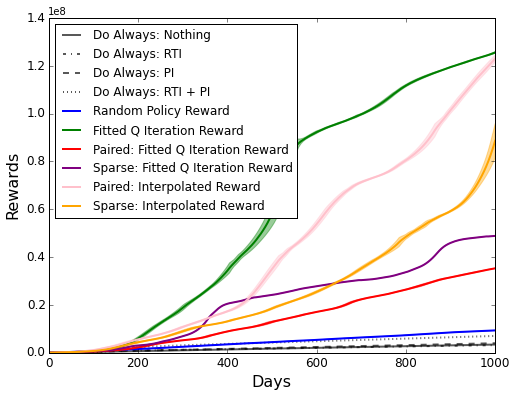

In [79]:
nsteps = states_baseline0.shape[1]
d = np.arange(nsteps) * 5
plt.figure(figsize=(8,6))
plt.plot(d,np.cumsum(rewards_baseline0[0,:]), color='black', lw=2, alpha=.65, label="Do Always: Nothing")
plt.plot(d,np.cumsum(rewards_baseline1[0,:]), color='black', linestyle='-.',lw=2, alpha=.65,label="Do Always: RTI")
plt.plot(d,np.cumsum(rewards_baseline2[0,:]), color='black', linestyle='--',lw=2, alpha=.65,label="Do Always: PI")
plt.plot(d,np.cumsum(rewards_baseline3[0,:]), color='black', linestyle=':', lw=2, alpha=.65,label="Do Always: RTI + PI")
plt.plot(d,rand_mean, color='blue', lw=2, label="Random Policy Reward")
plt.plot(d,fq_rewards_mean, color='green', lw=2, label="Fitted Q Iteration Reward")
plt.plot(d,fqp_rewards_mean, color='red', lw=2, label="Paired: Fitted Q Iteration Reward")
plt.plot(d,fqs_rewards_mean, color='purple', lw=2, label="Sparse: Fitted Q Iteration Reward")
plt.plot(d,fqpi_rewards_mean, color='pink', lw=2, label="Paired: Interpolated Reward")
plt.plot(d,fqsi_rewards_mean, color='orange', lw=2, label="Sparse: Interpolated Reward")
plt.fill_between(d, rand_lower, rand_upper, color='blue', alpha=.4)
plt.fill_between(d, fq_lower, fq_upper, color='green', alpha=.4)
plt.fill_between(d, fqp_lower, fqp_upper, color='red', alpha=.4)
plt.fill_between(d, fqs_lower, fqs_upper, color='purple', alpha=.4)
plt.fill_between(d, fqpi_lower, fqpi_upper, color='magenta', alpha=.4)
plt.fill_between(d, fqsi_lower, fqsi_upper, color='orange', alpha=.4)
plt.ylabel('Rewards', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc=0)